# Infer Pooled Model Parameters from Individuals in Lung Cancer Erlotinib High Dose Group

## Show data

In [1]:
import erlotinib as erlo

# Get data
data = erlo.DataLibrary().lung_cancer_high_erlotinib_dose_group()

# Create scatter plots of data
fig = erlo.plots.PKTimeSeriesPlot()
fig.add_data(data, biomarker='Plasma concentration')
fig.set_axis_labels(
    time_label=r'$\text{Time in day}$', 
    dose_label=r'$\text{Dose amount in mg}$',
    biom_label=r'$\text{Plasma conc. in ng/mL}$')
fig.show()

fig = erlo.plots.PDTimeSeriesPlot()
fig.add_data(data, biomarker='Tumour volume')
fig.set_axis_labels(xlabel=r'$\text{Time in day}$', ylabel=r'$\text{Tumour volume in cm}^3$')
fig.show()

**Figure 1:** Visualisation of the measured tumour growth in 8 mice with patient-derived lung cancer implants.

## Visualise posterior distribution

In [2]:
import os
import xarray as xr

# Import posterior
path = os.getcwd()
posterior = xr.open_dataset(path + '/posteriors/pooled.nc')

# Plot marginal posteriors
fig = erlo.plots.MarginalPosteriorPlot()
fig.add_data(data=posterior)

fig.show()

**Figure 2:** Marginal posterior distributions of model parameters. The y axis displays the sampled parameter value, and the x axis the binned number of samples.

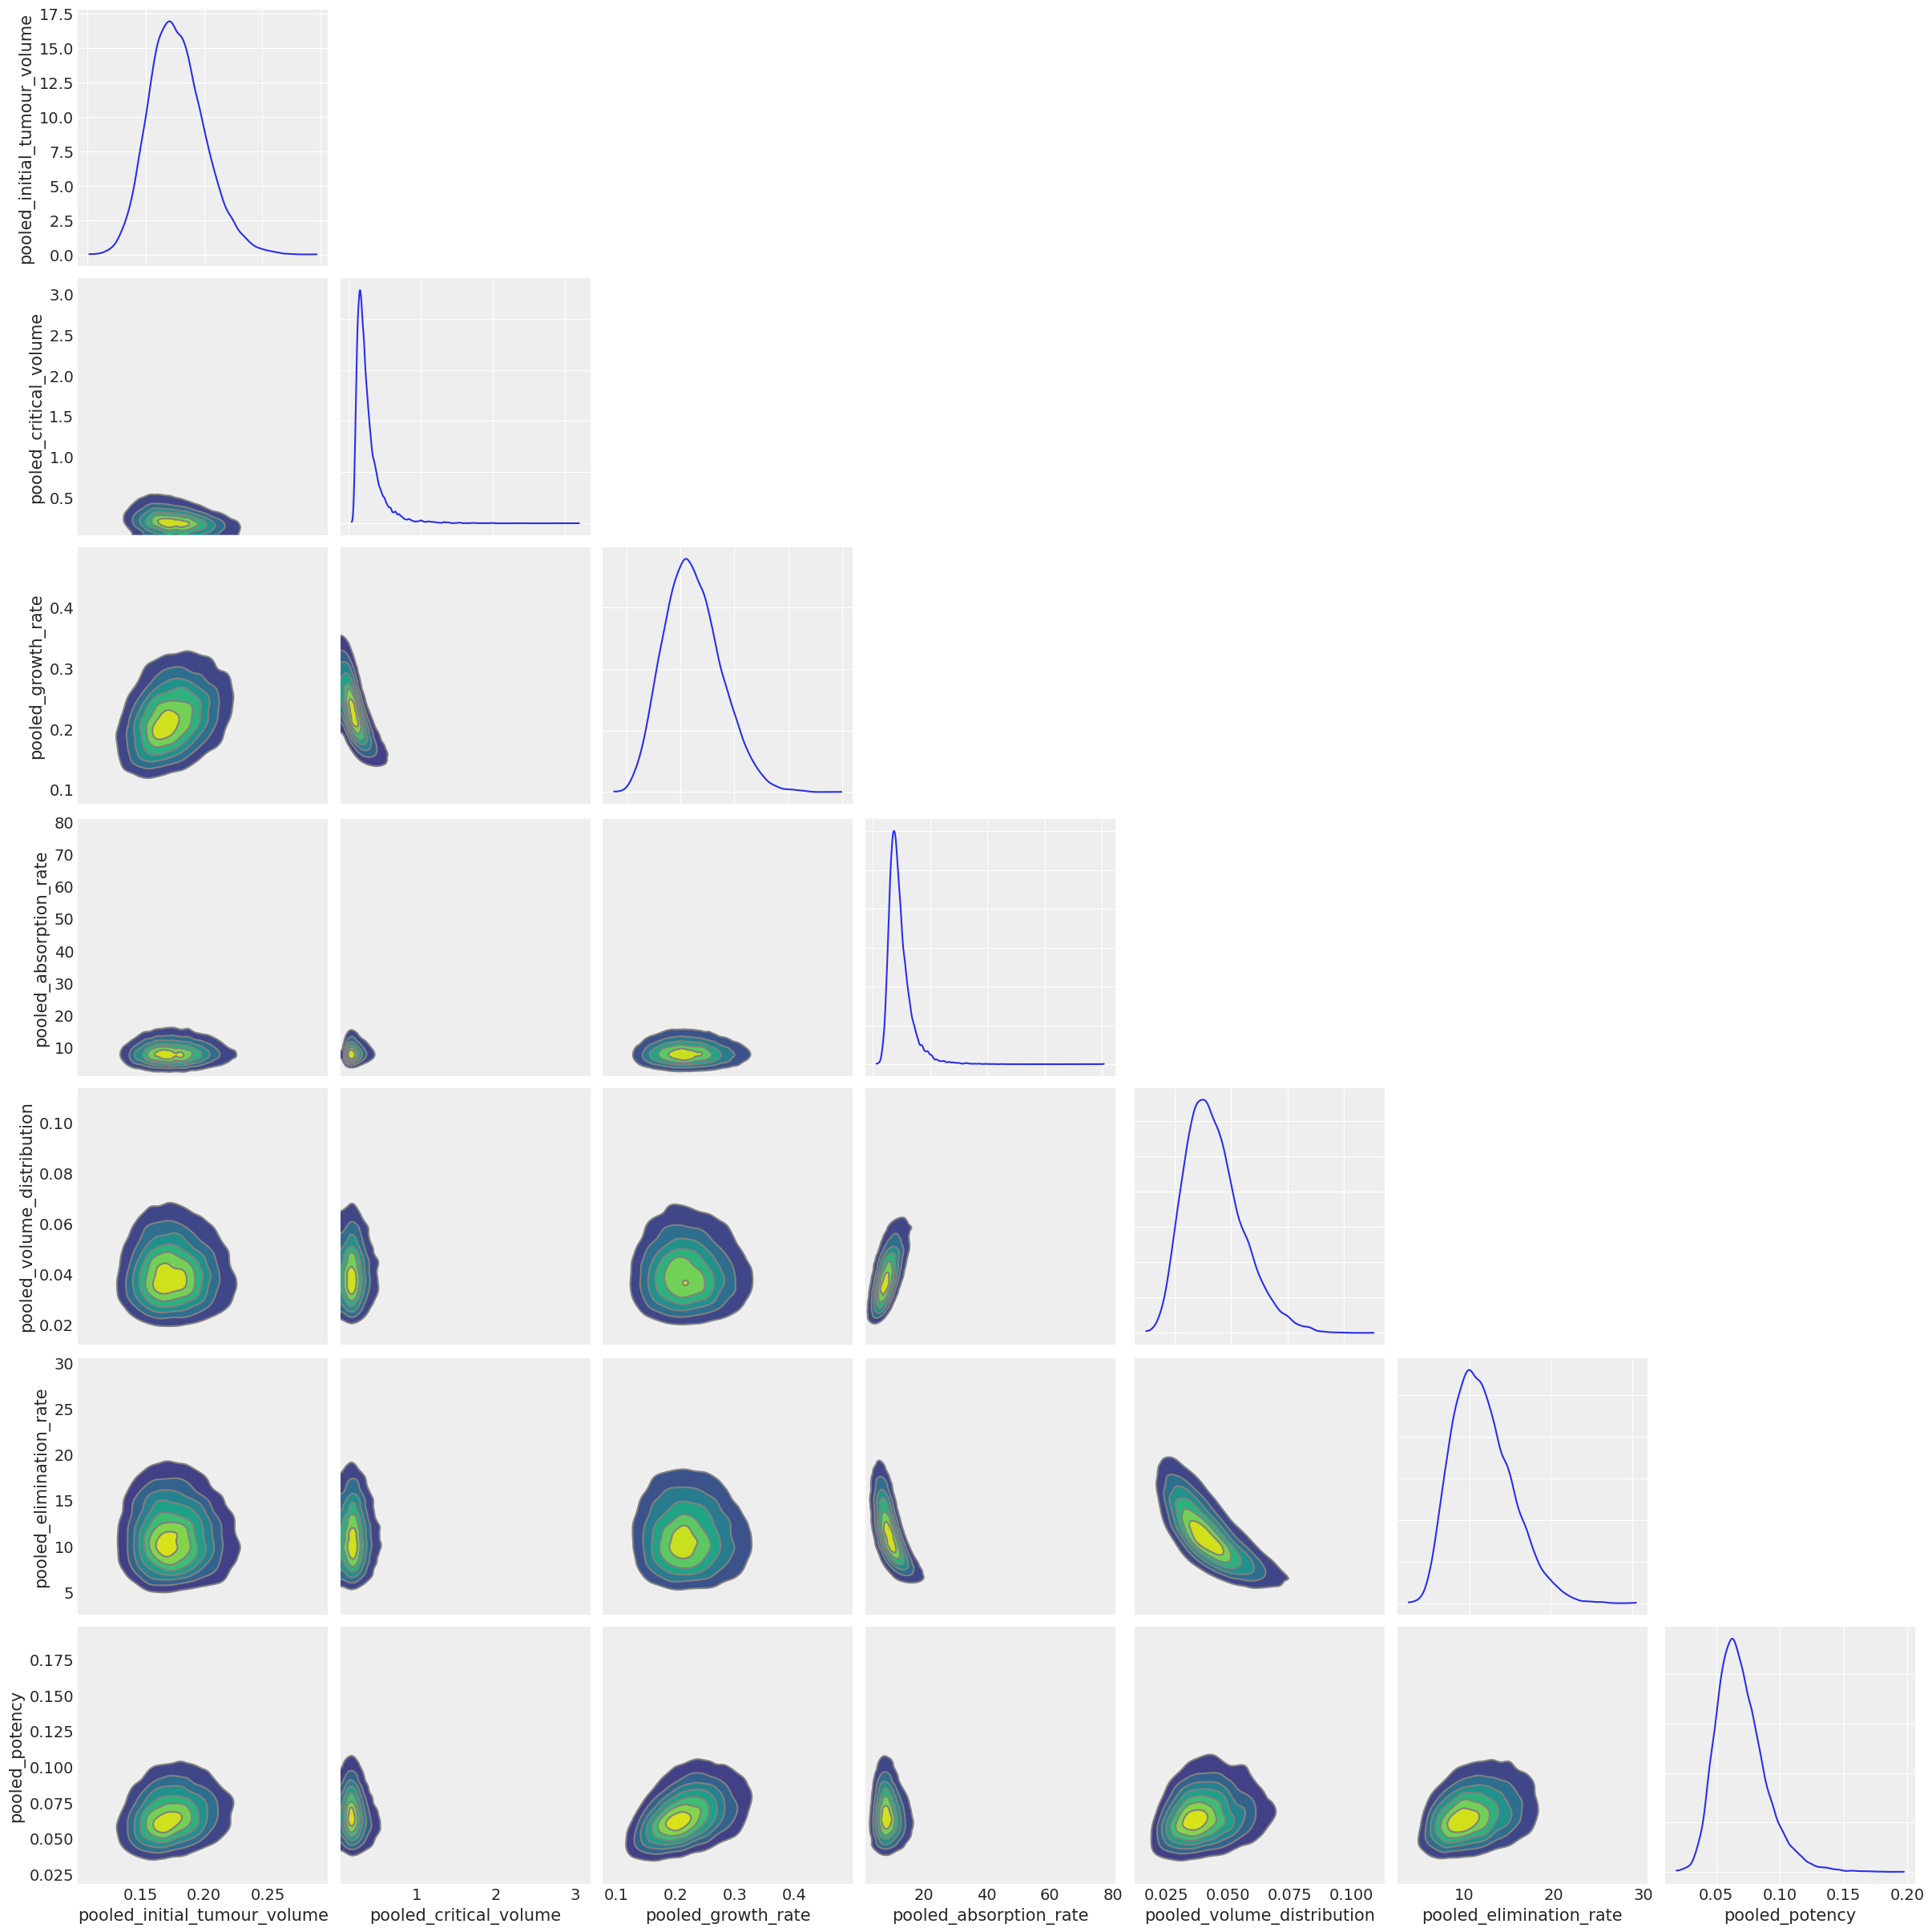

In [3]:
import arviz as az
import matplotlib.pyplot as plt
az.style.use("arviz-darkgrid")

temp = posterior[[
    'pooled_initial_tumour_volume',
    'pooled_critical_volume',
    'pooled_growth_rate',
    'pooled_absorption_rate',
    'pooled_volume_distribution',
    'pooled_elimination_rate',
    'pooled_potency']]
az.plot_pair(temp, kind='kde', marginals=True, figsize=(24, 24))
plt.show()

**Figure 3:** 2 dimensional marginal posterior distributions of model parameters. The x and y axis represent values of different model parameters and the colouring indicate low (blue) to high (yellow) probability mass.

## Build model

In [5]:
# Define mechanistic model
path = erlo.ModelLibrary().erlotinib_tumour_growth_inhibition_model()
mechanistic_model = erlo.PharmacokineticModel(path)
mechanistic_model.set_administration(compartment='central', direct=False)
mechanistic_model.set_parameter_names(names={
    'central.drug_amount': 'Initial plasma drug amount in mg',
    'dose.drug_amount': 'Initial dose comp. drug amount in mg',
    'central.size': 'Volume of distribution in L',
    'dose.absorption_rate': 'Absorption rate in 1/d',
    'myokit.elimination_rate': 'Elimination rate in 1/d',
    'myokit.tumour_volume': 'Initial tumour volume in cm^3',
    'myokit.critical_volume': 'Critical volume in cm^3',
    'myokit.kappa': 'Potency in L/mg/day',
    'myokit.lambda': 'Exponential growth rate in 1/day'})
mechanistic_model.set_outputs([
    'central.drug_concentration',
    'myokit.tumour_volume'])
mechanistic_model.set_output_names({
    'central.drug_concentration': 'Plasma conc. in ng/mL',
    'myokit.tumour_volume': 'Tumour volume in cm^3'})

# Define error model
error_models = [
    erlo.ConstantAndMultiplicativeGaussianErrorModel(),  # Plasma conc.
    erlo.ConstantAndMultiplicativeGaussianErrorModel()]  # Tumour volume

# Define population model
population_models = [
    erlo.PooledModel(),  # Initial tumour volume
    erlo.PooledModel(),  # Volume of distribution
    erlo.PooledModel(),  # Absorption rate
    erlo.PooledModel(),  # Critical volume
    erlo.PooledModel(),  # Elimination rate
    erlo.PooledModel(),  # Potency
    erlo.PooledModel(),  # Growth rate
    erlo.PooledModel(),  # Plasma conc. Sigma base
    erlo.PooledModel(),  # Plasma conc. Sigma rel.
    erlo.PooledModel(),  # Tumour volume Sigma base
    erlo.PooledModel()]  # Tumour volume Sigma rel.

# Compose model and not identified parameters
problem = erlo.ProblemModellingController(mechanistic_model, error_models)
problem.fix_parameters({
    'Initial plasma drug amount in mg': 0,
    'Initial dose comp. drug amount in mg': 0})
problem.set_population_model(population_models)

### Visualise posterior predictive distribution

In [11]:
import os
import numpy as np
import xarray as xr

# Define posterior predictive model
predictive_model = problem.get_predictive_model()
param_map = {
    'Pooled Initial tumour volume in cm^3': 'pooled_initial_tumour_volume',
    'Pooled Critical volume in cm^3': 'pooled_critical_volume',
    'Pooled Exponential growth rate in 1/day': 'pooled_growth_rate',
    'Pooled Plasma conc. in ng/mL Sigma base': 'pooled_plasma_concentration_sigma_base',
    'Pooled Plasma conc. in ng/mL Sigma rel.': 'pooled_plasma_concentration_sigma_rel',
    'Pooled Absorption rate in 1/d': 'pooled_absorption_rate',
    'Pooled Volume of distribution in L': 'pooled_volume_distribution',
    'Pooled Elimination rate in 1/d': 'pooled_elimination_rate',
    'Pooled Potency in L/mg/day': 'pooled_potency',
    'Pooled Tumour volume in cm^3 Sigma base': 'pooled_tumour_volume_sigma_base',
    'Pooled Tumour volume in cm^3 Sigma rel.': 'pooled_tumour_volume_sigma_rel'}
posterior_predictive_model = erlo.PosteriorPredictiveModel(
    predictive_model, posterior, param_map)

# Set dosing regimen
problem.set_data(data, 
    output_biomarker_dict={
        'Plasma conc. in ng/mL': 'Plasma concentration',
        'Tumour volume in cm^3': 'Tumour volume'})
regimen = problem.get_dosing_regimens()['67']
mechanistic_model = posterior_predictive_model.get_submodels()['Mechanistic model']
mechanistic_model.simulator.set_protocol(regimen)

# Sample from posterior predictive model
times = np.linspace(0, 30, num=200)
n_samples = 200
samples = posterior_predictive_model.sample(times, n_samples)

# Visualise posterior predictive distributions
fig = erlo.plots.PDPredictivePlot()
fig.add_prediction(data=samples, biomarker='Plasma conc. in ng/mL')
fig.add_data(data, biomarker='Plasma concentration')
fig.set_axis_labels(xlabel=r'$\text{Time in day}$', ylabel=r'$\text{Plasma conc. in ng/mL}^3$')
fig.show()

fig = erlo.plots.PDPredictivePlot()
fig.add_prediction(data=samples, biomarker='Tumour volume in cm^3')
fig.add_data(data, biomarker='Tumour volume')
fig.set_axis_labels(xlabel=r'$\text{Time in day}$', ylabel=r'$\text{Tumour volume in cm}^3$')
fig.show()

**Figure 4:** Posterior predictive model of the plasma concentration and tumour volume over time in the population assuming a pooled population model. The posterior predictive model is approximated by 200 samples for each of 200 equidistant time points. The scatter data visualises the data which was used for the inference.